Fetching dataset...
Dataset loaded and preprocessed.
Starting incremental training over 30 folds...
  Processing Fold 1/30...
  Processing Fold 2/30...
  Processing Fold 3/30...
  Processing Fold 4/30...
  Processing Fold 5/30...
  Processing Fold 6/30...
  Processing Fold 7/30...
  Processing Fold 8/30...
  Processing Fold 9/30...
  Processing Fold 10/30...
  Processing Fold 11/30...
  Processing Fold 12/30...
  Processing Fold 13/30...
  Processing Fold 14/30...
  Processing Fold 15/30...
  Processing Fold 16/30...
  Processing Fold 17/30...
  Processing Fold 18/30...
  Processing Fold 19/30...
  Processing Fold 20/30...
  Processing Fold 21/30...
  Processing Fold 22/30...
  Processing Fold 23/30...
  Processing Fold 24/30...
  Processing Fold 25/30...
  Processing Fold 26/30...
  Processing Fold 27/30...
  Processing Fold 28/30...
  Processing Fold 29/30...
  Processing Fold 30/30...

Evaluation complete. Results stored in DataFrame.
               model  fold  epoch_percentage  tr

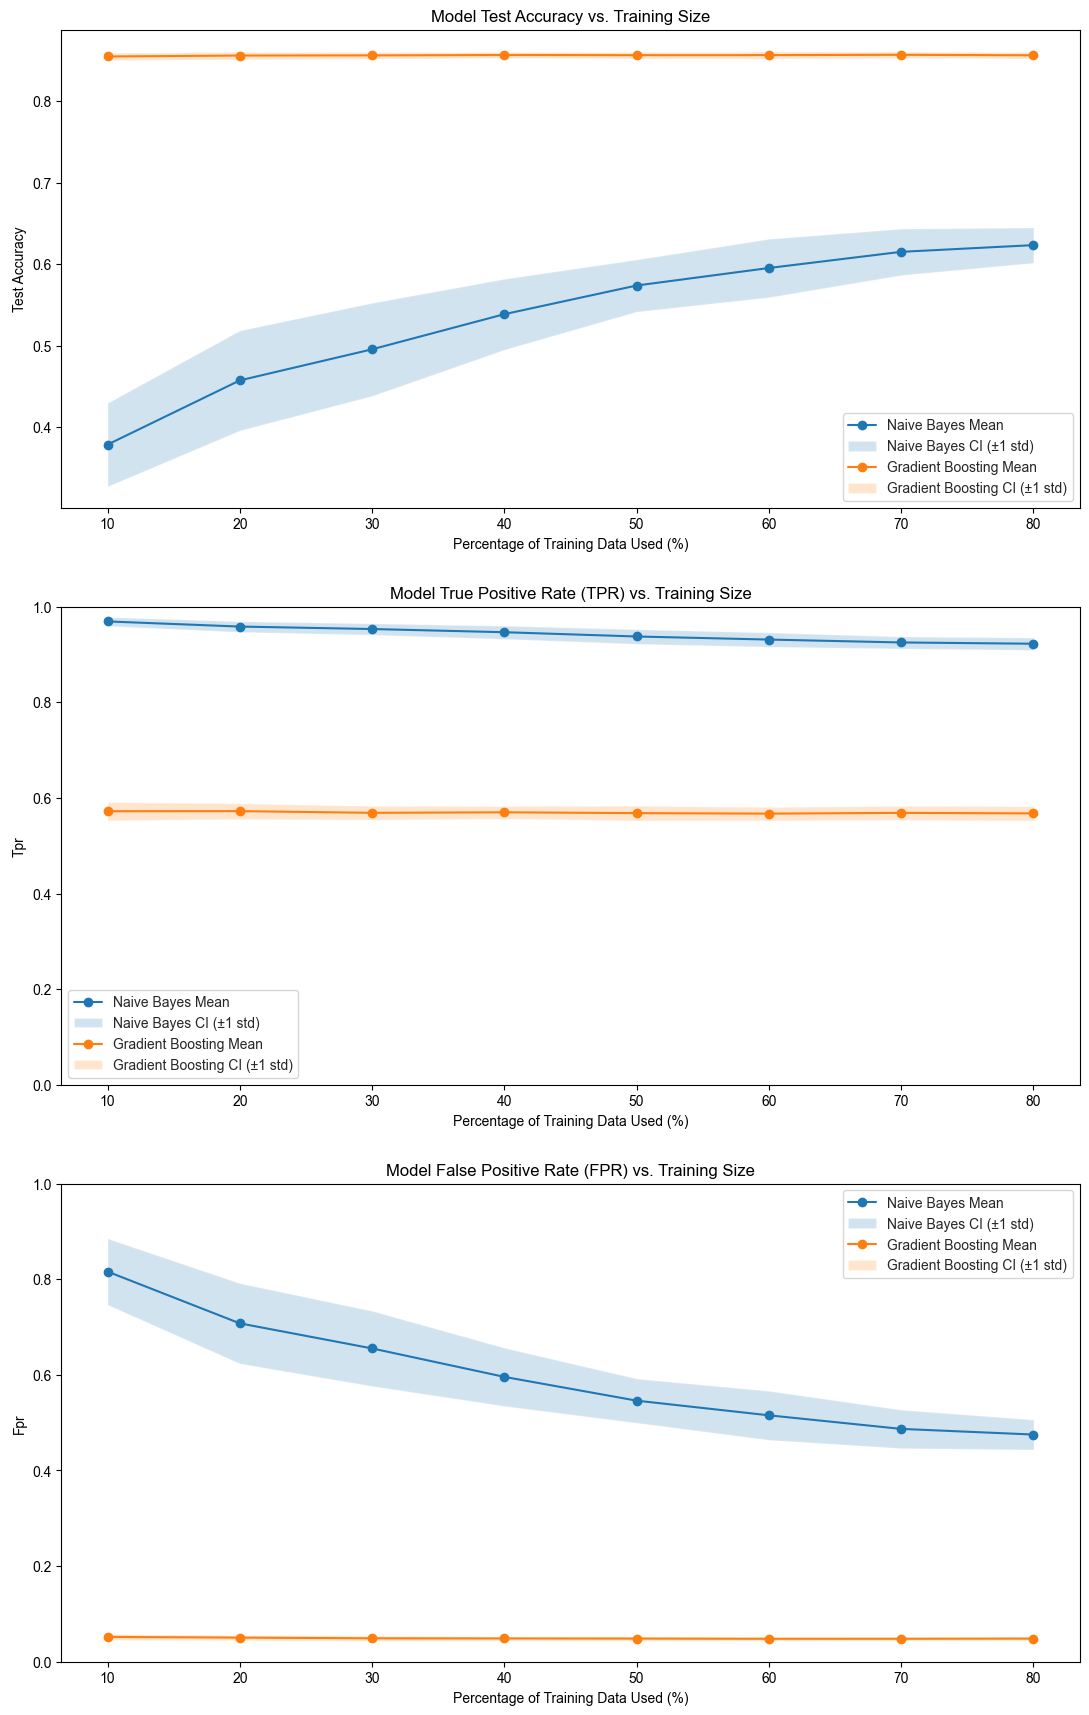


Script finished.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import wilcoxon
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Data Loading and Preparation
# ---------------------------------
print("Fetching dataset...")
# Using the 'Adult' (Census Income) dataset from OpenML
adult = fetch_openml(name='adult', version=2, as_frame=True, parser='auto')
df = adult.frame
# For demonstration speed, let's use a smaller subset of the data
# df = df.sample(n=10000, random_state=42) 
X = adult.data
y = adult.target

# Drop rows with missing values for simplicity
df.dropna(inplace=True)
X = df.drop('class', axis=1)
y = df['class']

# Encode the binary target variable to 0 and 1
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Dataset loaded and preprocessed.")

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include=['category', 'object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

## 2. Model Definitions
# --------------------
model_gnb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', GaussianNB())])

model_gbt = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=50))])

models = {
    'Naive Bayes': model_gnb,
    'Gradient Boosting': model_gbt
}

## 3. Incremental Training and Evaluation Loop
# ---------------------------------------------
# Define epochs as percentages of the training data
epoch_percentages = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

# Set up repeated cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_folds = cv.get_n_splits()

results_list = []

print(f"Starting incremental training over {n_folds} folds...")
for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y_encoded)):
    print(f"  Processing Fold {fold_idx + 1}/{n_folds}...")
    # Get the full training and test sets for this fold
    X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test = y_encoded[train_index], y_encoded[test_index]

    for epoch_perc in epoch_percentages:
        # Create a stratified subset of the training data for this epoch
        # We only need the training part of this split
        subset_size = int(epoch_perc * len(X_train_full))
        if subset_size < 2: continue # Ensure subset is large enough

        X_train_subset, _, y_train_subset, _ = train_test_split(
            X_train_full, y_train_full, train_size=subset_size,
            stratify=y_train_full, random_state=42
        )

        for model_name, model_template in models.items():
            # Clone the model to ensure a fresh start for each run
            model = clone(model_template)
            
            # Fit the model on the current subset
            model.fit(X_train_subset, y_train_subset)
            
            # --- Training Metrics ---
            y_train_pred = model.predict(X_train_subset)
            train_acc = accuracy_score(y_train_subset, y_train_pred)

            # --- Testing Metrics ---
            y_test_pred = model.predict(X_test)
            test_acc = accuracy_score(y_test, y_test_pred)
            
            # Confusion matrix to calculate TPR and FPR
            tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()
            
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
            
            # Store results
            results_list.append({
                'model': model_name,
                'fold': fold_idx,
                'epoch_percentage': int(epoch_perc * 100),
                'train_accuracy': train_acc,
                'test_accuracy': test_acc,
                'tpr': tpr,
                'fpr': fpr
            })

results_df = pd.DataFrame(results_list)
print("\nEvaluation complete. Results stored in DataFrame.")
print(results_df.head())


## 4. Statistical Analysis (Wilcoxon Test at Each Epoch)
# --------------------------------------------------------
alpha = 0.01
print(f"\n--- Wilcoxon Signed-Rank Test (alpha={alpha}) ---")
print("Comparing Test Accuracy at each training epoch:\n")

for epoch_perc in sorted(results_df['epoch_percentage'].unique()):
    scores_gnb = results_df[(results_df['model'] == 'Naive Bayes') & (results_df['epoch_percentage'] == epoch_perc)]['test_accuracy']
    scores_gbt = results_df[(results_df['model'] == 'Gradient Boosting') & (results_df['epoch_percentage'] == epoch_perc)]['test_accuracy']
    
    # Perform the test only if we have data for both
    if len(scores_gbt) > 0 and len(scores_gnb) > 0:
        stat, pvalue = wilcoxon(scores_gbt, scores_gnb)
        
        if pvalue < alpha:
            mean_gbt = scores_gbt.mean()
            mean_gnb = scores_gnb.mean()
            winner = "Gradient Boosting" if mean_gbt > mean_gnb else "Naive Bayes"
            print(f"Epoch {epoch_perc}%: Significant difference found (p={pvalue:.4f}). Winner: {winner}")
        else:
            print(f"Epoch {epoch_perc}%: No significant difference found (p={pvalue:.4f}).")

## 5. Plotting Convergence with Confidence Intervals
# ----------------------------------------------------
def plot_metric_convergence(df, metric, title, ax):
    """Helper function to plot a metric's convergence for both models."""
    sns.set_style("whitegrid")
    
    for model_name in df['model'].unique():
        model_df = df[df['model'] == model_name]
        
        # Group by epoch and calculate mean and std for the metric
        agg_df = model_df.groupby('epoch_percentage')[metric].agg(['mean', 'std']).reset_index()
        
        # Plot the mean line
        ax.plot(agg_df['epoch_percentage'], agg_df['mean'], label=f'{model_name} Mean', marker='o')
        
        # Plot the confidence interval (mean +/- std)
        ax.fill_between(
            agg_df['epoch_percentage'],
            agg_df['mean'] - agg_df['std'],
            agg_df['mean'] + agg_df['std'],
            alpha=0.2,
            label=f'{model_name} CI (±1 std)'
        )
        
    ax.set_xlabel('Percentage of Training Data Used (%)')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title)
    ax.legend()
    ax.set_xticks(sorted(df['epoch_percentage'].unique()))

print("\nGenerating plots...")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.tight_layout(pad=5.0)

# Plot for Test Accuracy
plot_metric_convergence(results_df, 'test_accuracy', 'Model Test Accuracy vs. Training Size', axes[0])

# Plot for True Positive Rate (TPR)
plot_metric_convergence(results_df, 'tpr', 'Model True Positive Rate (TPR) vs. Training Size', axes[1])
axes[1].set_ylim(0, 1) # TPR is between 0 and 1

# Plot for False Positive Rate (FPR)
plot_metric_convergence(results_df, 'fpr', 'Model False Positive Rate (FPR) vs. Training Size', axes[2])
axes[2].set_ylim(0, 1) # FPR is between 0 and 1

plt.show()

print("\nScript finished.")

Fetching dataset...
Running analysis on a random sample of 10000 records.

Starting model evaluation (50 total runs)...

--- Evaluating Model: Naive Bayes ---
  Processing Fold 1/10... [Overall Progress: 1/50, ETA: 00:00:00]
  Processing Fold 2/10... [Overall Progress: 2/50, ETA: 00:00:28]
  Processing Fold 3/10... [Overall Progress: 3/50, ETA: 00:00:36]
  Processing Fold 4/10... [Overall Progress: 4/50, ETA: 00:00:40]
  Processing Fold 5/10... [Overall Progress: 5/50, ETA: 00:00:42]
  Processing Fold 6/10... [Overall Progress: 6/50, ETA: 00:00:42]
  Processing Fold 7/10... [Overall Progress: 7/50, ETA: 00:00:41]
  Processing Fold 8/10... [Overall Progress: 8/50, ETA: 00:00:39]
  Processing Fold 9/10... [Overall Progress: 9/50, ETA: 00:00:40]
  Processing Fold 10/10... [Overall Progress: 10/50, ETA: 00:00:40]

--- Evaluating Model: Logistic Regression ---
  Processing Fold 1/10... [Overall Progress: 11/50, ETA: 00:00:39]
  Processing Fold 2/10... [Overall Progress: 12/50, ETA: 00:00:42

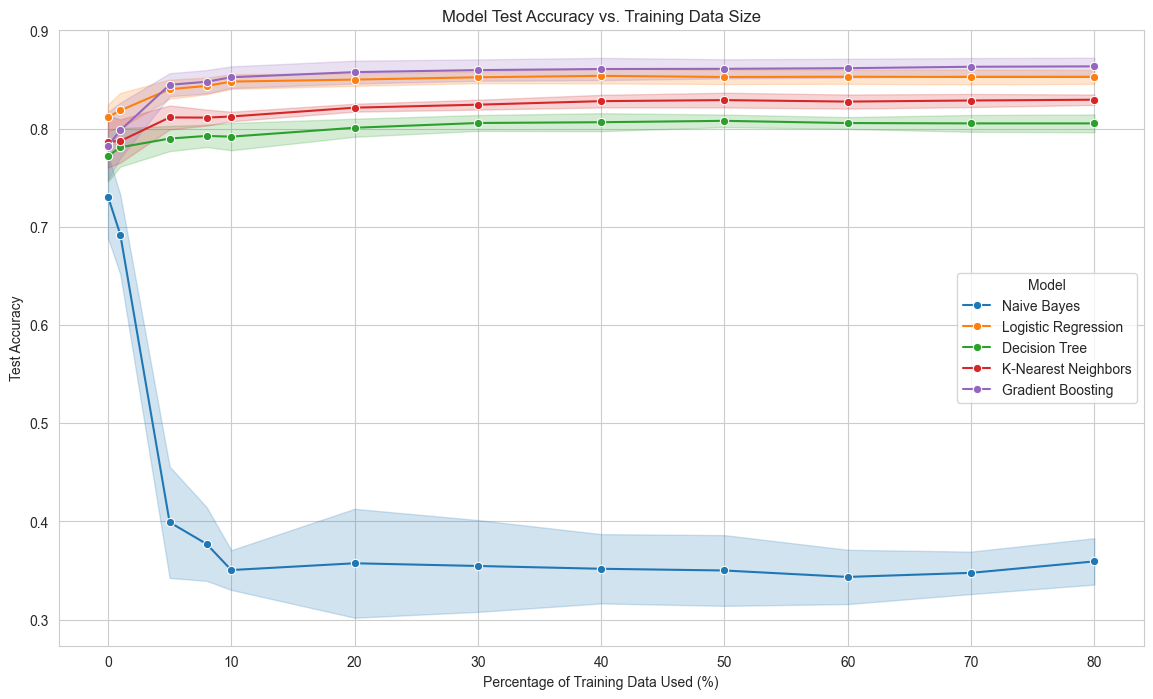


Script finished.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # For ETA calculation
from sklearn.base import clone
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
# Import stats tools for ANOVA and assumption checks
from scipy.stats import f_oneway, shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Data Loading and Preparation
# ---------------------------------
print("Fetching dataset...")
adult = fetch_openml(name='adult', version=2, as_frame=True, parser='auto')
df = adult.frame
df.dropna(inplace=True)
df = df.sample(n=10000, random_state=42)
print(f"Running analysis on a random sample of {len(df)} records.")

X = df.drop('class', axis=1)
y = df['class']
y_encoded = LabelEncoder().fit_transform(y)

categorical_features = X.select_dtypes(include=['category', 'object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

## 2. Model Definitions
# --------------------
models = {
    'Naive Bayes': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())]),
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42))]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))]),
    'K-Nearest Neighbors': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=50))])
}

## 3. Incremental Training with Progress and ETA
# -----------------------------------------------
epoch_percentages = 
n_splits = 5
n_repeats = 2
n_total_runs = len(models) * n_splits * n_repeats
results_list = []
run_count = 0
start_time = time.time()

print(f"\nStarting model evaluation ({n_total_runs} total runs)...")

# Loop over each model to create INDEPENDENT samples
for model_id, (model_name, model_template) in enumerate(models.items()):
    print(f"\n--- Evaluating Model: {model_name} ---")
    
    # Use a different random_state for each model to ensure independent folds
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42 + model_id)
    
    for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y_encoded)):
        run_count += 1
        
        # ETA calculation
        elapsed_time = time.time() - start_time
        avg_time_per_run = elapsed_time / run_count
        eta_seconds = avg_time_per_run * (n_total_runs - run_count)
        eta_formatted = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
        
        print(f"  Processing Fold {fold_idx + 1}/{cv.get_n_splits()}... [Overall Progress: {run_count}/{n_total_runs}, ETA: {eta_formatted}]")

        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y_encoded[train_index], y_encoded[test_index]
        
        for epoch_perc in epoch_percentages:
            subset_size = int(epoch_perc * len(X_train_full))
            if subset_size < 2: continue
            
            X_train_subset, _, y_train_subset, _ = train_test_split(
                X_train_full, y_train_full, train_size=subset_size,
                stratify=y_train_full, random_state=42
            )
            
            model = clone(model_template)
            model.fit(X_train_subset, y_train_subset)
            y_test_pred = model.predict(X_test)
            test_acc = accuracy_score(y_test, y_test_pred)
            
            results_list.append({
                'model': model_name,
                'fold': f"{model_name}_{fold_idx}", # Unique fold ID
                'epoch_percentage': int(epoch_perc * 100),
                'test_accuracy': test_acc
            })

results_df = pd.DataFrame(results_list)
print("\nEvaluation complete.")

## 4. Statistical Analysis (One-Way ANOVA)
# -----------------------------------------
final_epoch_df = results_df[results_df['epoch_percentage'] == 80]
alpha = 0.01

print(f"\n--- Statistical Comparison at 80% Training Data (alpha={alpha}) ---")
print("Using One-Way ANOVA, which requires 3 assumptions:")

# --- Assumption 1: Independence of Observations ---
print("\n✅ 1. Independence: Met by design. Each model was evaluated on a different set of random folds.")

model_scores = [final_epoch_df[final_epoch_df['model'] == name]['test_accuracy'].values for name in models.keys()]
all_scores = np.concatenate(model_scores)
model_labels = [name for name in models.keys() for _ in range(len(model_scores[0]))]

# --- Assumption 2: Normality of Residuals ---
print("\n❓ 2. Normality of Residuals: Checking with Shapiro-Wilk test...")
residuals = all_scores - all_scores.mean()
stat_shapiro, p_shapiro = shapiro(residuals)
print(f"   Shapiro-Wilk Test: p-value = {p_shapiro:.4f}")
if p_shapiro > alpha:
    print("   Conclusion: Residuals appear to be normally distributed (p > alpha). Assumption met.")
    normality_met = True
else:
    print("   Conclusion: Residuals do not appear to be normally distributed (p <= alpha). Assumption violated.")
    normality_met = False

# --- Assumption 3: Homogeneity of Variances ---
print("\n❓ 3. Homogeneity of Variances: Checking with Levene's test...")
stat_levene, p_levene = levene(*model_scores)
print(f"   Levene's Test: p-value = {p_levene:.4f}")
if p_levene > alpha:
    print("   Conclusion: Group variances appear to be equal (p > alpha). Assumption met.")
    homogeneity_met = True
else:
    print("   Conclusion: Group variances do not appear to be equal (p <= alpha). Assumption violated.")
    homogeneity_met = False
    
# --- Perform ANOVA and Post-hoc Test ---
if normality_met and homogeneity_met:
    print("\n## Step 1: One-Way ANOVA")
    print("All assumptions are met. Proceeding with ANOVA.")
    f_stat, p_anova = f_oneway(*model_scores)
    print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_anova:.6f}")

    if p_anova < alpha:
        print("Conclusion: The null hypothesis is rejected. There is a significant difference among the models.")
        print("\n## Step 2: Tukey's HSD Post-hoc Test")
        tukey_results = pairwise_tukeyhsd(endog=all_scores, groups=model_labels, alpha=alpha)
        print(tukey_results)
    else:
        print("Conclusion: Failed to reject the null hypothesis. No significant difference found.")
else:
    print("\nANOVA assumptions were not fully met. Results should be interpreted with caution.")
    print("A non-parametric alternative like the Kruskal-Wallis test would be more appropriate here.")

## 5. Plotting Convergence
# -------------------------
print("\n## Generating Plots...")
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.lineplot(data=results_df, x='epoch_percentage', y='test_accuracy', hue='model', errorbar='sd', marker='o')
ax.set_title('Model Test Accuracy vs. Training Data Size')
ax.set_xlabel('Percentage of Training Data Used (%)')
ax.set_ylabel('Test Accuracy')
ax.legend(title='Model')
plt.show()

print("\nScript finished.")

Fetching dataset...
Running analysis on a random sample of 10000 records.

Starting model evaluation (50 total runs)...

--- Evaluating Model: Naive Bayes ---
  Processing Fold 1/10... [Overall Progress: 1/50, ETA: 00:00:00]
  Processing Fold 2/10... [Overall Progress: 2/50, ETA: 00:00:26]
  Processing Fold 3/10... [Overall Progress: 3/50, ETA: 00:00:32]
  Processing Fold 4/10... [Overall Progress: 4/50, ETA: 00:00:34]
  Processing Fold 5/10... [Overall Progress: 5/50, ETA: 00:00:34]
  Processing Fold 6/10... [Overall Progress: 6/50, ETA: 00:00:35]
  Processing Fold 7/10... [Overall Progress: 7/50, ETA: 00:00:35]
  Processing Fold 8/10... [Overall Progress: 8/50, ETA: 00:00:34]
  Processing Fold 9/10... [Overall Progress: 9/50, ETA: 00:00:33]
  Processing Fold 10/10... [Overall Progress: 10/50, ETA: 00:00:33]

--- Evaluating Model: Logistic Regression ---
  Processing Fold 1/10... [Overall Progress: 11/50, ETA: 00:00:32]
  Processing Fold 2/10... [Overall Progress: 12/50, ETA: 00:00:34

,Decision Tree,Gradient Boosting,K-Nearest Neighbors,Logistic Regression,Naive Bayes
Decision Tree,1.000000,0.000130,0.369432,0.005776,0.369432
Gradient Boosting,0.000130,1.000000,0.026195,0.369432,0.000000
K-Nearest Neighbors,0.369432,0.026195,1.000000,0.271698,0.013262
Logistic Regression,0.005776,0.369432,0.271698,1.000000,0.000009
Naive Bayes,0.369432,0.000000,0.013262,0.000009,1.000000



(Cells highlighted in green show pairs with a statistically significant difference at alpha=0.01)

## Generating Plots...


<bound method Axes.set of <Axes: xlabel='epoch_percentage', ylabel='test_accuracy'>>

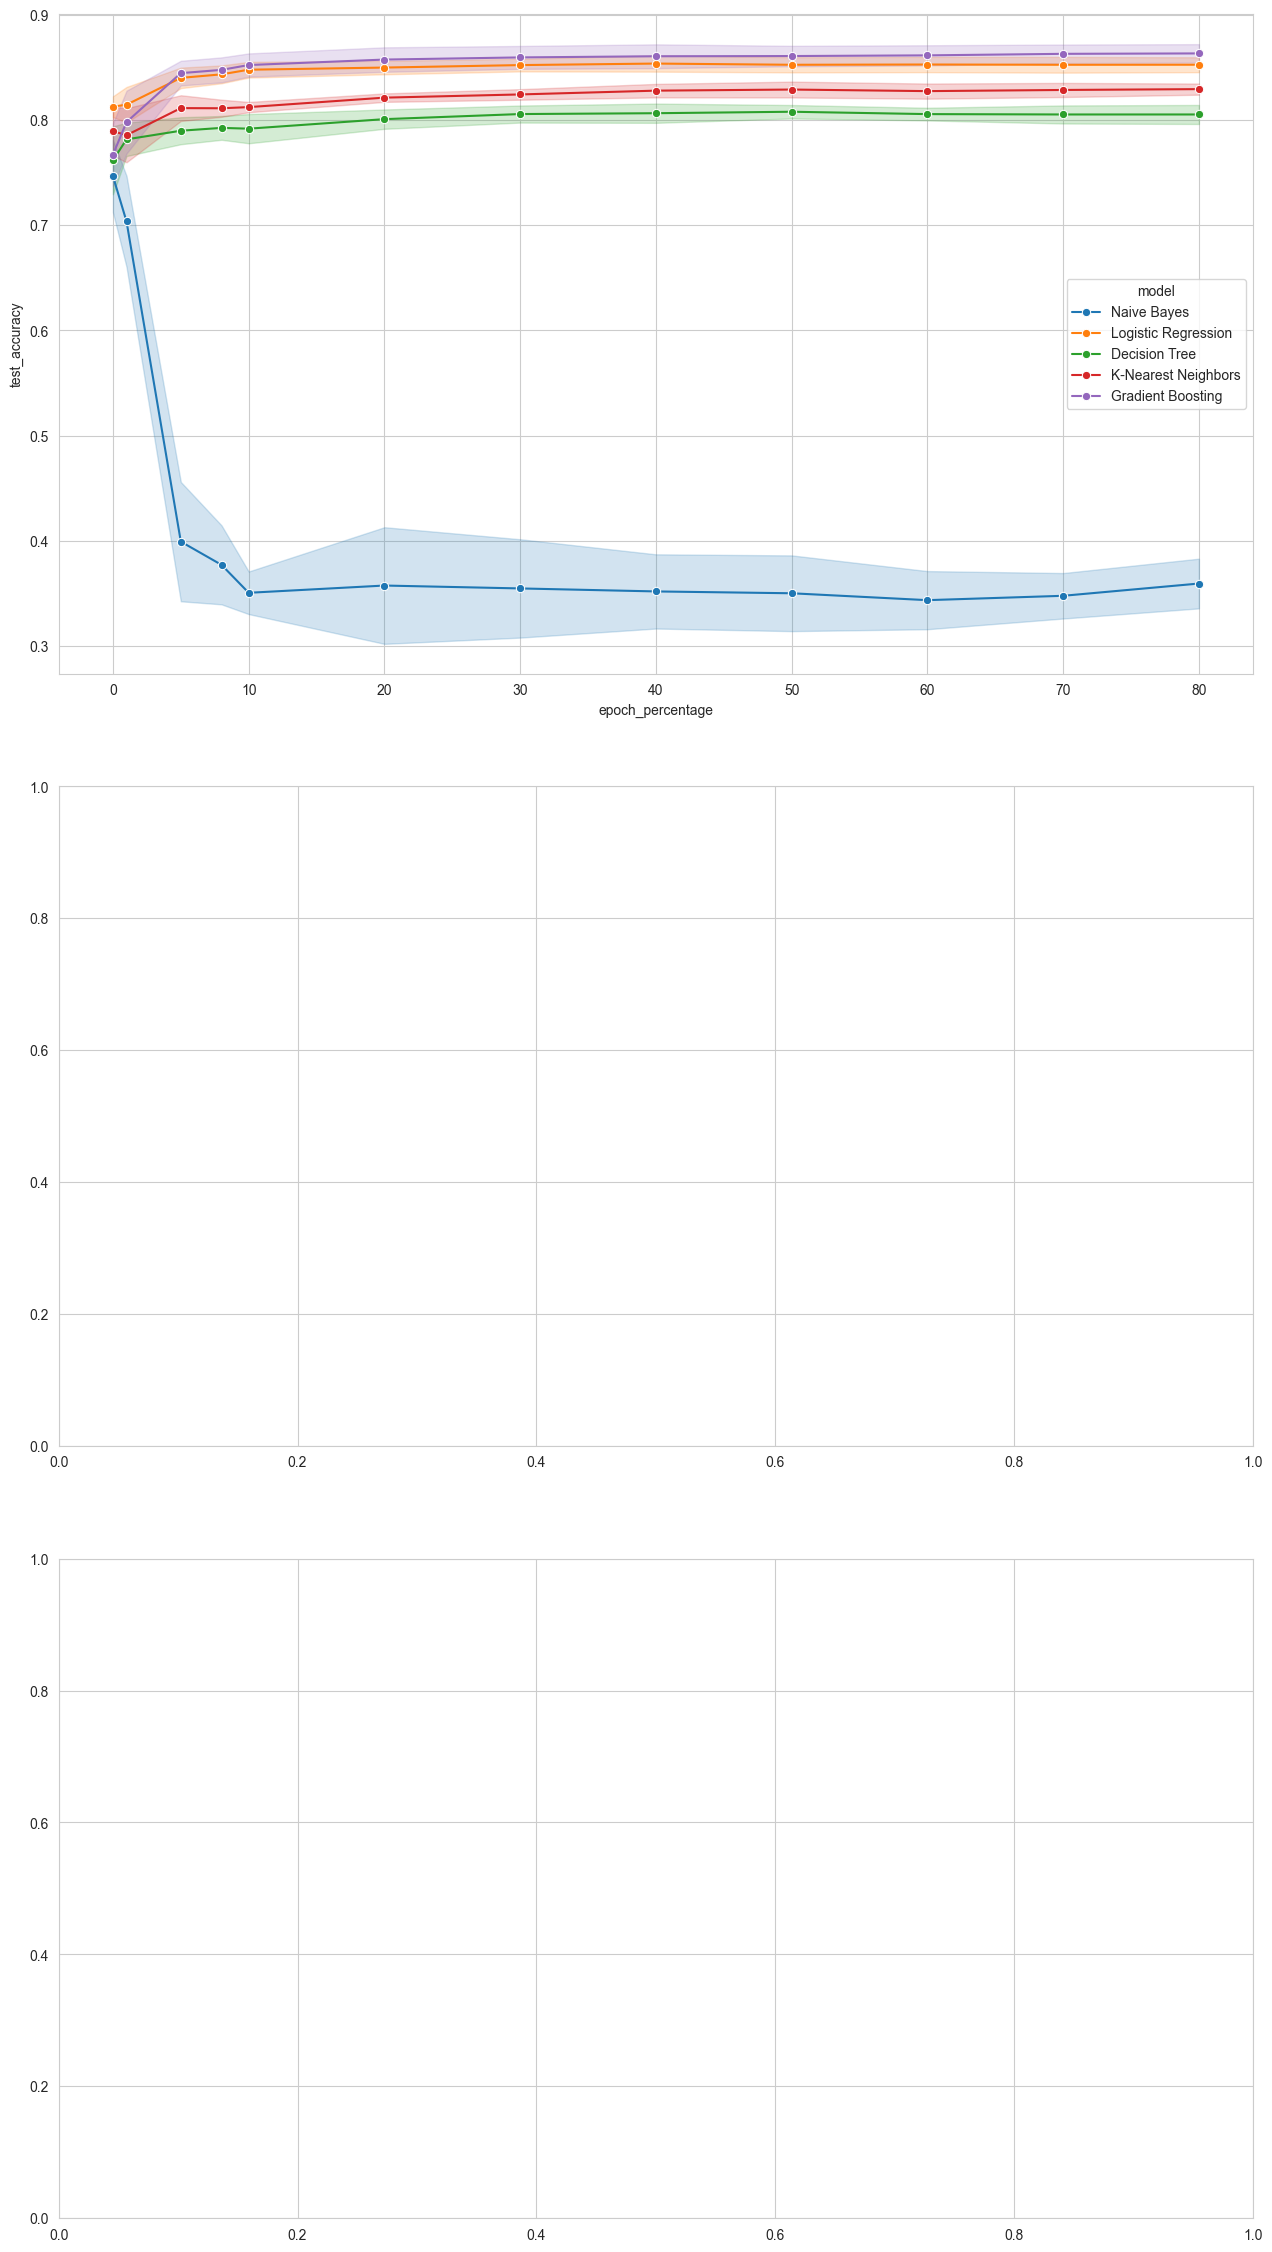

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # For ETA calculation
from sklearn.base import clone
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, confusion_matrix
# Import stats tools for ANOVA, Kruskal-Wallis, and assumption checks
from scipy.stats import f_oneway, shapiro, levene, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp # For Dunn's post-hoc test
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Data Loading and Preparation
# ---------------------------------
print("Fetching dataset...")
adult = fetch_openml(name='adult', version=2, as_frame=True, parser='auto')
df = adult.frame
df.dropna(inplace=True)
df = df.sample(n=10000, random_state=42)
print(f"Running analysis on a random sample of {len(df)} records.")

X = df.drop('class', axis=1)
y = df['class']
y_encoded = LabelEncoder().fit_transform(y)

categorical_features = X.select_dtypes(include=['category', 'object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

## 2. Model Definitions
# --------------------
models = {
    'Naive Bayes': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())]),
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42))]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))]),
    'K-Nearest Neighbors': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=50))])
}

## 3. Incremental Training with Progress and ETA
# -----------------------------------------------
# NOTE: Restored a sensible epoch range to ensure the final analysis at 80% works correctly.
epoch_percentages = np.array([0.005, 0.008, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # np.linspace(0.1, 0.8, 8)
n_splits = 5
n_repeats = 2
n_total_runs = len(models) * n_splits * n_repeats
results_list = []
run_count = 0
start_time = time.time()

print(f"\nStarting model evaluation ({n_total_runs} total runs)...")

# Loop over each model to create INDEPENDENT samples
for model_id, (model_name, model_template) in enumerate(models.items()):
    print(f"\n--- Evaluating Model: {model_name} ---")
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42 + model_id)
    
    for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y_encoded)):
        run_count += 1
        elapsed_time = time.time() - start_time
        avg_time_per_run = elapsed_time / run_count
        eta_seconds = avg_time_per_run * (n_total_runs - run_count)
        eta_formatted = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
        
        print(f"  Processing Fold {fold_idx + 1}/{cv.get_n_splits()}... [Overall Progress: {run_count}/{n_total_runs}, ETA: {eta_formatted}]")

        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y_encoded[train_index], y_encoded[test_index]
        
        for epoch_perc in epoch_percentages:
            subset_size = int(epoch_perc * len(X_train_full))
            if subset_size < 2: continue
            
            X_train_subset, _, y_train_subset, _ = train_test_split(
                X_train_full, y_train_full, train_size=subset_size,
                stratify=y_train_full, random_state=42
            )
            
            model = clone(model_template)
            model.fit(X_train_subset, y_train_subset)
            y_test_pred = model.predict(X_test)
            
            test_acc = accuracy_score(y_test, y_test_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            results_list.append({
                'model': model_name,
                'fold': f"{model_name}_{fold_idx}",
                'epoch_percentage': round(epoch_perc * 100),
                'test_accuracy': test_acc,
                'tpr': tpr,
                'fpr': fpr
            })

results_df = pd.DataFrame(results_list)
print("\nEvaluation complete.")

## 4. Statistical Analysis
# -------------------------
final_epoch_df = results_df[results_df['epoch_percentage'] == 80]
alpha = 0.01
print(f"\n--- Statistical Comparison at 80% Training Data (alpha={alpha}) ---")

# First, check assumptions for ANOVA
model_scores = [final_epoch_df[final_epoch_df['model'] == name]['test_accuracy'].values for name in models.keys()]
stat_levene, p_levene = levene(*model_scores)
residuals = np.concatenate(model_scores) - np.concatenate(model_scores).mean()
stat_shapiro, p_shapiro = shapiro(residuals)

if p_shapiro > alpha and p_levene > alpha:
    print("✅ ANOVA assumptions met. Proceeding with ANOVA and Tukey's HSD test.")
    f_stat, p_anova = f_oneway(*model_scores)
    print(f"\nANOVA F-statistic: {f_stat:.2f}, p-value: {p_anova:.4f}")
    if p_anova < alpha:
        print("Conclusion: Significant difference found.")
        all_scores = np.concatenate(model_scores)
        model_labels = [name for name in models.keys() for _ in range(len(model_scores[0]))]
        tukey_results = pairwise_tukeyhsd(endog=all_scores, groups=model_labels, alpha=alpha)
        print(tukey_results)
    else:
        print("Conclusion: No significant difference found among models.")
else:
    print("\n❌ ANOVA assumptions were not met. Switching to non-parametric tests.")
    print(f"   Normality (Shapiro-Wilk p-value): {p_shapiro:.4f}")
    print(f"   Homogeneity of Variances (Levene p-value): {p_levene:.4f}")
    
    # --- Step 1: Kruskal-Wallis H Test ---
    print("\n## Step 1: Kruskal-Wallis H Test")
    stat_kruskal, p_kruskal = kruskal(*model_scores)
    print(f"Kruskal-Wallis H-statistic: {stat_kruskal:.4f}, p-value: {p_kruskal:.6f}")

    if p_kruskal < alpha:
        print("Conclusion: A significant difference exists among the models' performances.")
        
        # --- Step 2: Dunn's Post-hoc Test ---
        print("\n## Step 2: Dunn's Post-hoc Test (with Holm-Bonferroni correction)")
        # Use p_adjust='holm' for a good balance between power and error control
        p_dunn = sp.posthoc_dunn(final_epoch_df, val_col='test_accuracy', group_col='model', p_adjust='holm')
        
        print("\nP-values for pairwise comparisons (Dunn's test):")
        p_dunn_styled = p_dunn.style.applymap(lambda x: 'background-color: lightgreen' if x < alpha else '')
        display(p_dunn_styled)
        print(f"\n(Cells highlighted in green show pairs with a statistically significant difference at alpha={alpha})")
    else:
        print("Conclusion: No significant difference was found among the models.")

## 5. Plotting Convergence for All Metrics
# -----------------------------------------
print("\n## Generating Plots...")
fig, axes = plt.subplots(3, 1, figsize=(14, 24))
fig.tight_layout(pad=6.0)

# Plot 1: Test Accuracy
sns.lineplot(data=results_df, x='epoch_percentage', y='test_accuracy', hue='model', errorbar='sd', marker='o', ax=axes[0])
axes[0].set_title('Model Test Accuracy vs. Training Data Size', fontsize=16)
axes[0].set_xlabel('Percentage of Training Data Used (%)')
axes[0].set_ylabel('Test Accuracy')
axes[0].legend(title='Model')

# Plot 2: True Positive Rate (TPR)
sns.lineplot(data=results_df, x='epoch_percentage', y='tpr', hue='model', errorbar='sd', marker='o', ax=axes[1])
axes[1].set_title('Model True Positive Rate (TPR) vs. Training Data Size', fontsize=16)
axes[1].set_xlabel('Percentage of Training Data Used (%)')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].set_ylim(0, 1)
axes[1].legend(title='Model')

# Plot 3: False Positive Rate (FPR)
sns.lineplot(data=results_df, x='epoch_percentage', y='fpr', hue='model', errorbar='sd', marker='o', ax=axes[2])
axes[2].set_title('Model False Positive Rate (FPR) vs. Training Data Size', fontsize=16)
axes[2].set_xlabel('Percentage of Training Data Used (%)')
axes[2].set_ylabel('False Positive Rate')
axes[2].set_ylim(0, 1)
axes[2].legend(title='Model')

plt.show()

print("\nScript finished.")


## Generating Plots...


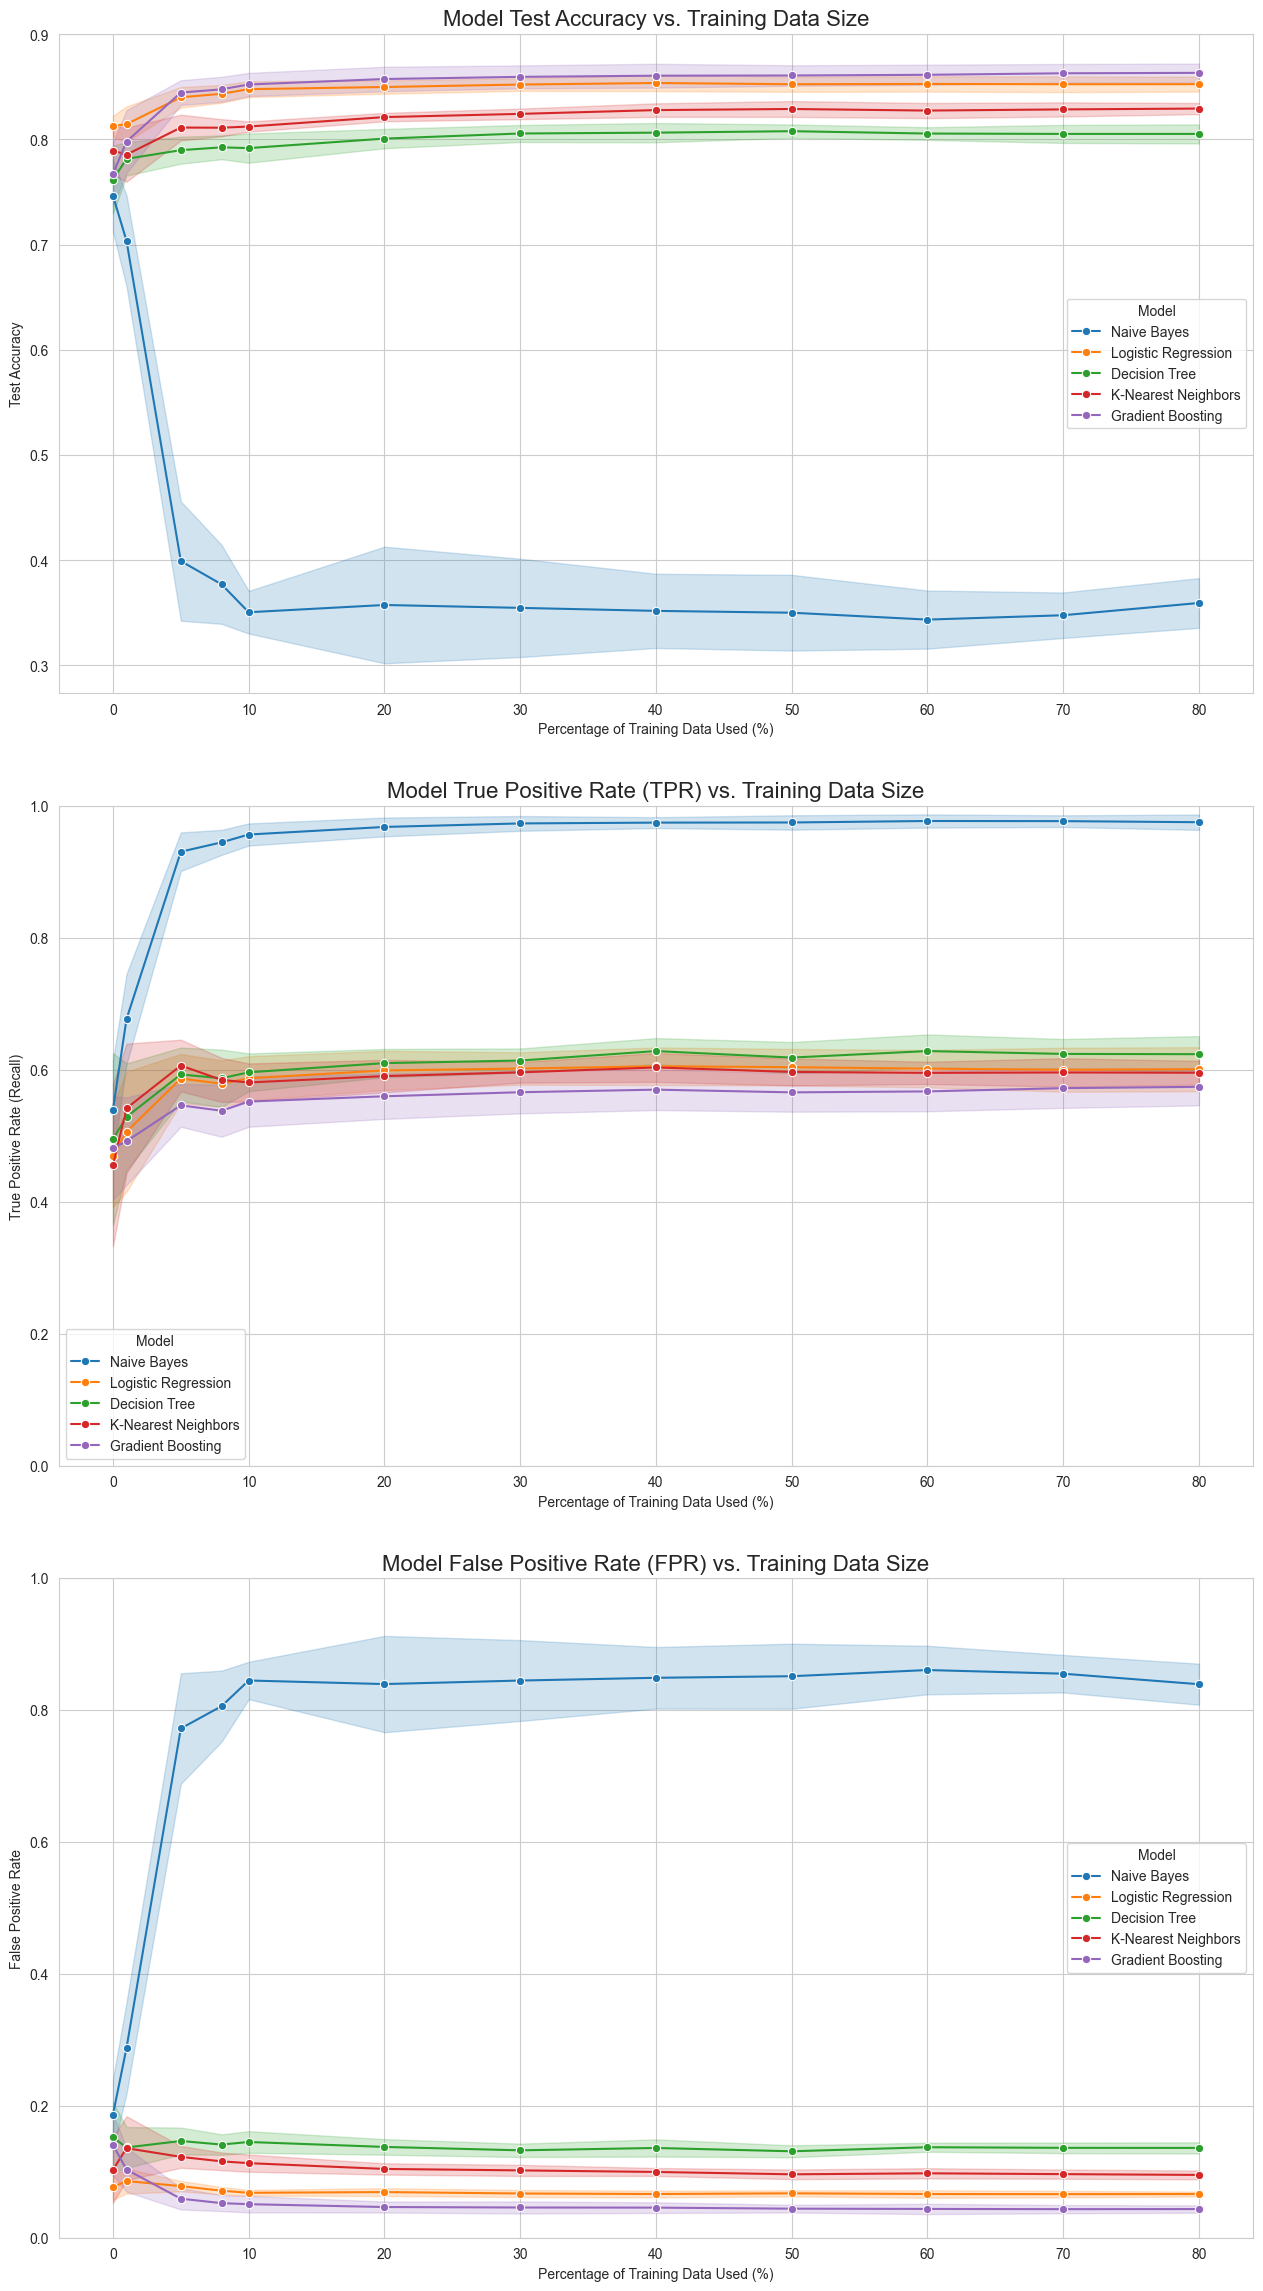


Script finished.


In [10]:
## 5. Plotting Convergence for All Metrics
# -----------------------------------------
print("\n## Generating Plots...")
fig, axes = plt.subplots(3, 1, figsize=(14, 24))
fig.tight_layout(pad=6.0)

# Plot 1: Test Accuracy
sns.lineplot(data=results_df, x='epoch_percentage', y='test_accuracy', hue='model', errorbar='sd', marker='o', ax=axes[0])
axes[0].set_title('Model Test Accuracy vs. Training Data Size', fontsize=16)
axes[0].set_xlabel('Percentage of Training Data Used (%)')
axes[0].set_ylabel('Test Accuracy')
axes[0].legend(title='Model')

# Plot 2: True Positive Rate (TPR)
sns.lineplot(data=results_df, x='epoch_percentage', y='tpr', hue='model', errorbar='sd', marker='o', ax=axes[1])
axes[1].set_title('Model True Positive Rate (TPR) vs. Training Data Size', fontsize=16)
axes[1].set_xlabel('Percentage of Training Data Used (%)')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].set_ylim(0, 1)
axes[1].legend(title='Model')

# Plot 3: False Positive Rate (FPR)
sns.lineplot(data=results_df, x='epoch_percentage', y='fpr', hue='model', errorbar='sd', marker='o', ax=axes[2])
axes[2].set_title('Model False Positive Rate (FPR) vs. Training Data Size', fontsize=16)
axes[2].set_xlabel('Percentage of Training Data Used (%)')
axes[2].set_ylabel('False Positive Rate')
axes[2].set_ylim(0, 1)
axes[2].legend(title='Model')

plt.show()

print("\nScript finished.")